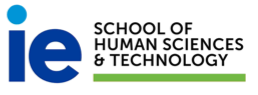


# **PySpark Advanced EDA*


---

### ACME corporation is trying to understand eating habits in different countries and, given that they don’t have any team able to do any data analysis, they are asking for help. Fortunately, IE students are learning Spark and they are keen to involve and help ACME corporation to make this world a better place. Additionally, his class has to work on a group assignment and this looks like a perfect scenario to bring everything together.

### The global dataset has been segmented into countries and each group will work on the different subsets. ACME corporation is looking forward to meeting all the groups in the final presentation in order to get insights and start outlining a plan to make world citizens healthier and live over 100 years.

### This is serious, the future of the world is in your hands.
 
### Mr. Road Runner
### Chief Health Officer
### **ACME corporation**

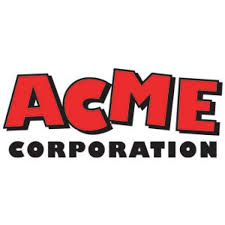

---

### First of all, it's needed to import all the libraries that are used in the development 

In [1]:
import findspark
findspark.init()
from pyspark.sql.session import SparkSession
from IPython.display import display, Markdown
import pyspark.sql.functions as F 
from pyspark.sql.types import IntegerType, ArrayType, StringType, DoubleType

### Let's create our Spark Session and create our dataframe based on the data, in our case our Country is Belgium (the file was renamed to openfood2.csv)

In [2]:
spark = SparkSession.builder\
            .appName("Open Foods Belgium")\
            .getOrCreate()

In [3]:
openfood = spark.read.option('inferSchema','true').option("sep","\t").option('header','true').csv("../openfood2.csv")

### Let's check the amount of columns of the dataframe, the amount of rows and check how the data is structured in a row 

In [4]:
len(openfood.columns)

184

In [5]:
openfood.count()

58577

In [6]:
openfood.distinct().count()

58577

### There's no duplicated values, good news!

In [7]:
openfood.show(1)

+------+--------------------+-------+----------+-------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+--------------+------+-----------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+---------+--------------+------------+----------------+---------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------+------------+---------------------------+-------------------------+------------------------------+---------------------------------------+-------------------------------------+------------------------------------------+----------------+----------------+----------+-------------+-------------+--------------------+--------------------+---

### Let's check the schema of our dataframe and the data types inferred 

In [8]:
openfood.printSchema()

root
 |-- code: double (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: integer (nullable = true)
 |-- created_datetime: timestamp (nullable = true)
 |-- last_modified_t: integer (nullable = true)
 |-- last_modified_datetime: timestamp (nullable = true)
 |-- product_name: string (nullable = true)
 |-- abbreviated_product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_text: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- origins_en: string (nullable = true)
 |-- manufacturing_places: str

# Questions about this dataset:
    
    
    
## ● Find the oldest product
## ● Find the newest product
## ● Average product age, where age means how long the product has been in the system.
## ● List of other countries where products are sold too.
## ● Identify category of products and the compute:

###        ○ Number of products by category
###        ○ List containing names of products by category

##    ● Identify traces and compute:

###        ○ Number of products by trace
###        ○ List containing names of products by trace

##    ● Data quality analysis on fields of interest (see appendix 1):

###        ○ Number of products with complete info.
###        ○ % of products without complete analysis per 100g
###        ○ % of products without additives info
###        ○ % of products without traces info

##    ● Data profiling on fields of interest (see appendix)

---

# Find the oldest product

In [9]:
#Q1:Oldest product
print ("\nThe oldest product in the dataset is \n")
openfood.select("code","creator","product_name","created_datetime").groupBy("code","creator","product_name").agg(F.min("created_datetime")).sort('min(created_datetime)', ascending=True)\
.withColumnRenamed('min(created_datetime)','created_datetime').limit(1).show(truncate=False)


The oldest product in the dataset is 

+-----------------+--------+------------------------+-------------------+
|code             |creator |product_name            |created_datetime   |
+-----------------+--------+------------------------+-------------------+
|3.017760038409E12|marianne|Lulu La Barquette Fraise|2012-02-11 16:07:23|
+-----------------+--------+------------------------+-------------------+



--- 

# Find the newest product

In [10]:
#Q2:Newest product
print ("\nThe newest product in the dataset is \n")
openfood.select("code","creator","product_name","created_datetime").groupBy("code","creator","product_name").agg(F.max("created_datetime")).sort('max(created_datetime)', ascending=False)\
.withColumnRenamed('max(created_datetime)','created_datetime').limit(1).show(truncate=False)


The newest product in the dataset is 

+-----------------+-------+---------------------+-------------------+
|code             |creator|product_name         |created_datetime   |
+-----------------+-------+---------------------+-------------------+
|7.622210854537E12|kiliweb|Knapperige haverrepen|2021-02-22 23:28:39|
+-----------------+-------+---------------------+-------------------+



---

# Average product age, where age means how long the product has been in the system.

In [11]:
#Q3: Average product age, where age means how long the product has been in the system.

(openfood.withColumn('today',F.current_date()).withColumn('age',(F.datediff(F.col('today'),F.to_date(F.col('created_datetime'))))/365).drop('today')).select('age').agg(F.avg('age').alias('Average Age')).show()

+-----------------+
|      Average Age|
+-----------------+
|2.025693098955887|
+-----------------+



---

# List of other countries where products are sold too.

#### First of all we have to check the data inside the column 

In [12]:
openfood.select("countries_en").distinct().show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### we converted our column into an array 

In [13]:
openfood=(openfood.withColumn(
    "countries_en",
    F.split(F.col("countries_en"), ",").cast(ArrayType(StringType())).alias("countries_en")
))

#### This array we put into a string in other column

In [14]:
openfood=openfood.withColumn('countries_str',F.col('countries_en').cast(StringType()))

#### With the date in our new column we generate a list of all countries, we filtered the data
#### we changed the field to uppercase in order to filter effectively
#### we excluded in the filter all the countries that has BELG or BÉLG
#### we grouped the data and count the values per country  

In [15]:
countries=openfood.withColumn('list', F.split(F.regexp_extract(F.trim('countries_str'), '\[(.*)\]',1), ',')).\
select(F.explode('list').alias('exploded')).filter(~((F.upper(F.col('exploded')).like('%BELG%'))|(F.upper(F.col('exploded')).like('%BÉLG%')))).\
groupby('exploded').count().sort('count',ascending=False).withColumnRenamed('exploded','Country').\
withColumnRenamed('count','no_of_countries')

#### Finally we showed the final list, as we can see Belgium is out of the list

In [16]:
countries.select('Country').distinct().show(truncate=False)

+-----------------------+
|Country                |
+-----------------------+
| Canada-english        |
| Poland-polski         |
| Rumunia               |
| Irlande               |
| Australia-english     |
| Luxembourg            |
| Uruguay               |
| Tunisia               |
| Vereinigtes-konigreich|
| fr:σερβία             |
| Německo               |
| Nigeria               |
| Moldova               |
| En                    |
| Dominican Republic    |
| Maroc                 |
| Polen                 |
| Colombia              |
| Colombia-espanol      |
| Ireland               |
+-----------------------+
only showing top 20 rows



--- 

# Identify category of products and the compute:

# ○ Number of products by category

In [17]:
#### First of all we have to check the data inside the column 

In [18]:
openfood.select('categories_en').distinct().show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|categories_en                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Plant-based foods and beverages,Plant-based foods,Fruits and vegetables based foods,Vegetables based foods,Tomatoes and their products,Strained tomatoes                              |
|Dietary supplements,Spirulina                                                                                                                                                         |
|Plant-based foods and beverages,Plant-based foods,Cereals and potatoes,See

#### we converted our column into an array in a new column and check the data of the new column 

In [19]:
openfood=(openfood.withColumn(
    "categories_str",
    F.split(F.col("categories_en"), ",").cast(ArrayType(StringType())).alias("categories_str")
))
openfood.select('categories_en','categories_str').show()

+--------------------+--------------------+
|       categories_en|      categories_str|
+--------------------+--------------------+
|                null|                null|
|                null|                null|
|Plant-based foods...|[Plant-based food...|
|Groceries,Sauces,...|[Groceries, Sauce...|
|Spreads,Salted sp...|[Spreads, Salted ...|
|Plant-based foods...|[Plant-based food...|
|Plant-based foods...|[Plant-based food...|
|Plant-based foods...|[Plant-based food...|
|Plant-based foods...|[Plant-based food...|
|                null|                null|
|                null|                null|
|Plant-based foods...|[Plant-based food...|
|Plant-based foods...|[Plant-based food...|
|                null|                null|
|                null|                null|
|Plant-based foods...|[Plant-based food...|
|                null|                null|
|Plant-based foods...|[Plant-based food...|
|Meats,Prepared me...|[Meats, Prepared ...|
|Plant-based foods...|[Plant-bas

#### we separate the categories in a list, we generate a group by and count by products

In [20]:
products_per_category=openfood.select(F.explode('categories_str').alias('Category'),'product_name').groupBy('Category').agg(F.count('product_name')).sort('count(product_name)', ascending=False).\
withColumnRenamed('count(product_name)','q_products')

print("\nNumber of products per category: \n")
products_per_category.show()


Number of products per category: 

+--------------------+----------+
|            Category|q_products|
+--------------------+----------+
|Plant-based foods...|      6185|
|   Plant-based foods|      5285|
|           Beverages|      2826|
|              Snacks|      2750|
|        Sweet snacks|      2224|
|             Dairies|      2094|
|Cereals and potatoes|      2085|
|     Fermented foods|      1554|
|Fermented milk pr...|      1511|
|Fruits and vegeta...|      1507|
|Cereals and their...|      1438|
|           Groceries|      1403|
|          Breakfasts|      1352|
|               Meals|      1302|
|             Spreads|      1291|
|               Meats|      1224|
|  Biscuits and cakes|      1075|
|             Cheeses|      1052|
|Plant-based bever...|      1036|
|              Sauces|      1010|
+--------------------+----------+
only showing top 20 rows



# ○ List containing names of products by category

In [21]:
### To create the list of categories and products, we create a list with all the categories and its products, and we generate a grouped dataframe
products_and_categories=openfood.select(F.explode('categories_str').alias('Category'),'product_name').distinct().sort('Category', ascending=False)

In [22]:
products_and_categories.show(truncate=False)

+--------------------------------+-----------------------------------------------------------------------------------+
|Category                        |product_name                                                                       |
+--------------------------------+-----------------------------------------------------------------------------------+
|شوكولاته                        |m&s food                                                                           |
|Époisses de Bourgogne           |Epoisses AOP                                                                       |
|Époisses de Bourgogne           |Epoisse                                                                            |
|xx:diepvries-vis                |Filet de poisson &quot;Bordelaise&quot;                                            |
|tr:dessert-au-chocolat-et-sésame|Halva Chocolat Sebahat                                                             |
|ru:батончик                     |Milky way     

In [23]:
prod_and_cat=products_and_categories.groupBy("Category").agg(F.collect_list("product_name").alias('products_per_category'))

print("List of categories and products\n")
prod_and_cat.show(truncate=False)

List of categories and products

+------------------------------------+--------------------------------------------------------------------------------+
|Category                            |products_per_category                                                           |
+------------------------------------+--------------------------------------------------------------------------------+
|fr:riz-noir                         |[Riz noir complet parfumé]                                                      |
|fr:roomijs                          |[Netflix & chill'd]                                                             |
|fr:roules-au-fromage                |[roulés au fromage]                                                             |
|fr:rum-flavored-beer                |[Rum flavoured beer, Rum Flavoured Beer]                                        |
|fr:sachet-de-the                    |[Kräuter Ingwer]                                                                |
|fr:sal

---

# ● Identify traces and compute:
# ○ Number of products by trace

#### First of all we have to check the data inside the column 

In [24]:
openfood.select('traces_en').distinct().show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------+
|traces_en                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------+
|Mustard,Nuts,Sesame seeds,Soybeans                                                                                      |
|Lait                                                                                                                    |
|Gluten,Nuts,fr:seigle-ble                                                                                               |
|Crustaceans,Fish,Gluten,Lupin,Milk,Molluscs,Soybeans                                                                    |
|Nuts,fr:oeufs-sesame-lupin                                                                                              |
|Nuts,Peanuts,So

#### we converted our column into an array in a new column and check the data of the new column 

In [25]:
openfood=(openfood.withColumn(
    "traces_str",
    F.split(F.col("traces_en"), ",").cast(ArrayType(StringType())).alias("traces_str")
))
openfood.select('traces_en','traces_str').show()

+------------------+--------------------+
|         traces_en|          traces_str|
+------------------+--------------------+
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|Milk,Nuts,Soybeans|[Milk, Nuts, Soyb...|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
|              null|                null|
+------------------+--------------

#### Finally we grouped the data by trace and count the products 

In [26]:
products_per_trace=openfood.select(F.explode('traces_str').alias('Traces'),'product_name').groupBy('Traces').agg(F.count('product_name')).sort('count(product_name)', ascending=False).\
withColumnRenamed('count(product_name)','q_products')

print("Number of products by trace:\n")
products_per_trace.show()

Number of products by trace:

+--------------------+----------+
|              Traces|q_products|
+--------------------+----------+
|                Nuts|      2162|
|                Milk|      1467|
|            Soybeans|      1378|
|              Gluten|      1084|
|                Eggs|       962|
|        Sesame seeds|       872|
|             Peanuts|       551|
|              Celery|       534|
|             Mustard|       510|
|                Fish|       259|
|               Lupin|       225|
|         Crustaceans|       212|
|            Molluscs|       174|
|Sulphur dioxide a...|       141|
|    fr:phenylalanine|        35|
|                None|        19|
|           fr:noyaux|        11|
|    fr:lait-d-amande|         9|
|       Phenylalanine|         6|
|                Oats|         6|
+--------------------+----------+
only showing top 20 rows



# ○ List containing names of products by trace

In [27]:
products_and_traces=openfood.select('product_name',F.explode('traces_str').alias('Traces')).distinct().sort('product_name', ascending=False)\

print("List of products and its traces:\n")
products_and_traces.show(truncate=False)

List of products and its traces:

+------------------------------------------------------+-------------------------------------+
|product_name                                          |Traces                               |
+------------------------------------------------------+-------------------------------------+
|Водка «Русский стандарт»                              |Gluten                               |
|épinards hachés à la crème                            |fr:contient-du-lait-avec-lactose     |
|épices Pour Poulet Boni Sélection                     |Mustard                              |
|Étoiles raisins au beurre                             |Soybeans                             |
|Étoiles raisins au beurre                             |Nuts                                 |
|Épices pour poulet                                    |Mustard                              |
|Épices pour Paella                                    |Gluten                               |
|Épices poulet  

In [28]:
prod_and_traces=products_and_traces.groupBy("Traces").agg(F.collect_list("product_name").alias('products_per_trace'))

print("List of traces and products\n")
prod_and_traces.show(truncate=False)

List of traces and products

+------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Traces                                                                                                                  |products_per_trace                                                                                                                                                    |
+------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|fr:schalenfruchte                                                                                   

---

# ● Data quality analysis on fields of interest (see appendix 1):
# ○ Number of products with complete info.



In [29]:
interest=['Creator','Created_datetime','Last_modified_datetime','Product_name','Countries_en','Traces_en','Additives_tags','Main_category_en','Image_url','Quantity','Packaging_tags','Categories_en','Ingredients_text','Additives_en','Energy-kcal_100g','Fat_100g','Saturated-fat_100g','Sugars_100g','salt_100g','sodium_100g']
interest

['Creator',
 'Created_datetime',
 'Last_modified_datetime',
 'Product_name',
 'Countries_en',
 'Traces_en',
 'Additives_tags',
 'Main_category_en',
 'Image_url',
 'Quantity',
 'Packaging_tags',
 'Categories_en',
 'Ingredients_text',
 'Additives_en',
 'Energy-kcal_100g',
 'Fat_100g',
 'Saturated-fat_100g',
 'Sugars_100g',
 'salt_100g',
 'sodium_100g']

#### A new df was created with no null values and count the rows of the df

In [30]:
print("Number of products with complete info:")
openfood_complete_prod_info=openfood.na.drop(subset=interest)
openfood_complete_prod_info.count()

Number of products with complete info:


1609

# ○ % of products without complete analysis per 100g

#### Identifying Fields with 100 g 

In [31]:
interest[-6:]

['Energy-kcal_100g',
 'Fat_100g',
 'Saturated-fat_100g',
 'Sugars_100g',
 'salt_100g',
 'sodium_100g']

#### Null values are deleted in order to obtain all completed values of the dataframe
#### To calculate the percentage of products without complete analysis per 100g
#### it's necessary to calculate (1 - (total_data_complete_100g / total_data_openfood))

In [32]:
openfood_complete_100g=openfood.na.drop(subset=interest[-6:])
print("% of products without complete analysis per 100g:\n")
percentage_incomplete_100g=(1-(openfood_complete_100g.count()/openfood.count()))*100
print("{:.3f}".format(percentage_incomplete_100g)+"%")

% of products without complete analysis per 100g:

26.092%


# ○ % of products without additives info

#### Null values are deleted in order to obtain all completed values of the dataframe
#### To calculate the percentage of products without complete additives info
#### it's necessary to calculate (1 - (total_data_complete_additives / total_data_openfood))

In [33]:
print("% of products without additives info:\n")
openfood_complete_additives=openfood.na.drop(subset='additives_en')
percentage_incomplete_adds=(1-(openfood_complete_additives.count()/openfood.count()))*100
print("{:.3f}".format(percentage_incomplete_adds)+"%")

% of products without additives info:

87.755%


# ○ % of products without traces info

#### Null values are deleted in order to obtain all completed values of the dataframe
#### To calculate the percentage of products without complete traces info
#### it's necessary to calculate (1 - (total_data_complete_traces / total_data_openfood))

In [34]:
print("% of products without traces info:\n")
openfood_complete_traces=openfood.na.drop(subset='traces_en')
percentage_incomplete_traces=(1-(openfood_complete_traces.count()/openfood.count()))*100
print("{:.3f}".format(percentage_incomplete_traces)+"%")

% of products without traces info:

92.582%


---

#   ● Data profiling on fields of interest (see appendix)

#### First of all, we need to filter all the columns of interest, to do that we used oor interest list to select the columns

In [35]:
openfood_interest=openfood.select(*interest)

In [36]:
openfood_interest.printSchema()

root
 |-- Creator: string (nullable = true)
 |-- Created_datetime: timestamp (nullable = true)
 |-- Last_modified_datetime: timestamp (nullable = true)
 |-- Product_name: string (nullable = true)
 |-- Countries_en: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Traces_en: string (nullable = true)
 |-- Additives_tags: string (nullable = true)
 |-- Main_category_en: string (nullable = true)
 |-- Image_url: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Packaging_tags: string (nullable = true)
 |-- Categories_en: string (nullable = true)
 |-- Ingredients_text: string (nullable = true)
 |-- Additives_en: string (nullable = true)
 |-- Energy-kcal_100g: double (nullable = true)
 |-- Fat_100g: double (nullable = true)
 |-- Saturated-fat_100g: double (nullable = true)
 |-- Sugars_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- sodium_100g: double (nullable = true)



#### Unique values per categorical columns

In [37]:
cat_cols = [f.name for f in openfood_interest.schema.fields if isinstance(f.dataType, StringType)]
for i in cat_cols:
    print("Unique values and its distribution for "+i+"\n")
    openfood_interest.select(i).groupBy(i).count().sort('count', ascending=False).show(truncate=True)

Unique values and its distribution for Creator

+--------------------+-----+
|             Creator|count|
+--------------------+-----+
|             kiliweb|43356|
|openfoodfacts-con...| 9662|
|     date-limite-app|  869|
|             spiegel|  228|
|            malikele|  213|
|              tacite|  191|
|                dada|  154|
|  openfood-ch-import|  127|
|            sebleouf|  116|
|       herrvirgilius|   85|
|              uliege|   82|
|          agamitsudo|   77|
|     sarah-erraddahi|   67|
|             tacinte|   56|
|              aleene|   51|
|            stephane|   49|
|             manuc66|   42|
|                 inf|   40|
|               arcko|   38|
|              elcoco|   38|
+--------------------+-----+
only showing top 20 rows

Unique values and its distribution for Product_name

+--------------------+-----+
|        Product_name|count|
+--------------------+-----+
|                null| 1642|
|     Filet de poulet|   93|
|          Mayonnaise|   68|
|  

#### Function to calculate missing values

In [38]:
def count_missings(spark_df,sort=True):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([F.count(F.when(F.isnull(c) | F.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [39]:
count_missings(openfood_interest)

,count
Traces_en,54232
Additives_en,51404
Additives_tags,51404
Packaging_tags,48007
Ingredients_text,46432
Main_category_en,39718
Categories_en,39718
Quantity,37593
salt_100g,12999
sodium_100g,12999


#### Computation of basic statistics for numerical values 

#### Identifying numerical values in the dataframe

In [40]:
dbl_cols = [f.name for f in openfood_interest.schema.fields if isinstance(f.dataType, DoubleType)]
dbl_cols

['Energy-kcal_100g',
 'Fat_100g',
 'Saturated-fat_100g',
 'Sugars_100g',
 'salt_100g',
 'sodium_100g']

In [41]:
for i in dbl_cols:
    print('\nData profiling for numerical values:\n')
    print("\nBasic Stats for column "+i+": \n")
    openfood_interest.select([F.mean(F.col(i)).alias('Mean'),F.min(F.col(i)).alias('min value'), F.max(F.col(i)).alias('max value'),F.stddev(F.col(i)).alias('Std Dev')]).show()
    print("Quartiles (25%,50%,75%) for column "+i+": "+ str(openfood_interest.approxQuantile(i, [0.25, 0.5, 0.75], 0))+'\n')
    print("Interquartile Range for column "+i+": "+str(openfood_interest.approxQuantile(i, [0.75], 0)[0]-openfood_interest.approxQuantile(i, [0.25], 0)[0])+("\n\n"))




Data profiling for numerical values:


Basic Stats for column Energy-kcal_100g: 

+------------------+---------+---------+-------------------+
|              Mean|min value|max value|            Std Dev|
+------------------+---------+---------+-------------------+
|219190.64245762164|      0.0|   1.0E10|4.678570479253063E7|
+------------------+---------+---------+-------------------+

Quartiles (25%,50%,75%) for column Energy-kcal_100g: [98.0, 252.0, 398.0]

Interquartile Range for column Energy-kcal_100g: 300.0



Data profiling for numerical values:


Basic Stats for column Fat_100g: 

+------------------+---------+---------+-----------------+
|              Mean|min value|max value|          Std Dev|
+------------------+---------+---------+-----------------+
|14.177612370113703|      0.0|    225.0|18.39657088283725|
+------------------+---------+---------+-----------------+

Quartiles (25%,50%,75%) for column Fat_100g: [0.7, 7.0, 22.0]

Interquartile Range for column Fat_100g: 21.3

---

# **Food Color Analysis**

### We obtained the list of food colours approved in the EU and created a DF with this information

### https://www.food.gov.uk/business-guidance/approved-additives-and-e-numbers

In [42]:
food_colours_eu=spark.createDataFrame([\
    ('E100','Curcumin'),('E101','Riboflavin'),('E101i','Riboflavin-5-phosphate'),('E102','Tartrazine'),\
                       ('E104','Quinoline yellow'),
                       ('E110','Sunset Yellow FCF; Orange Yellow S'),
                       ('E120','Cochineal; Carminic acid; Carmines'),
                       ('E122','Azorubine; Carmoisine'),('E123','Amaranth'),('E124','Ponceau 4R; Cochineal Red A'),\
                       ('E127','Erythrosine'),('E129','Allura Red AC'),('E131','Patent Blue V'),\
                       ('E132','lndigotine; Indigo Carmine'),('E133','Brilliant Blue FCF'),\
                       ('E140','Chlorophylls and chlorophyllins'),('E141','Copper complexes of chlorophyll and chlorophyllins'),\
                       ('E142','Green S'),('E150a','Plain caramel'),('E150b','Caustic sulphite caramel'),\
                       ('E150c','Ammonia caramel'),('E150d','Sulphite ammonia caramel'),\
                       ('E151','Brilliant Black BN; Black PN'),('E153','Vegetable carbon'),\
                       ('E155','Brown HT'),('E160a','Carotenes'),('E160b(i)','Annatto, bixin'),\
                       ('E160b(ii)','Annatto, norbixin'),('E160c','Paprika extract; Capsanthian; Capsorubin'),\
                       ('E160d','Lycopene'),('E160e','Beta-apo-8-carotenal (C30)'),('E161b','Lutein'),\
                       ('E161g','Canthaxanthin'),('E162','Beetroot Red; Betanin'),('E163','Anthocyanins'),\
                       ('E170','Calcium carbonate'),('E171','Titanium dioxide'),\
                       ('E172','Iron oxides and hydroxides'),('E173','Aluminium'),('E174','Silver'),\
                       ('E175','Gold'),('E180','Litholrubine BK')],['e_number','addtiive'])

In [43]:
food_colours_eu.show(50,truncate=False)

+---------+--------------------------------------------------+
|e_number |addtiive                                          |
+---------+--------------------------------------------------+
|E100     |Curcumin                                          |
|E101     |Riboflavin                                        |
|E101i    |Riboflavin-5-phosphate                            |
|E102     |Tartrazine                                        |
|E104     |Quinoline yellow                                  |
|E110     |Sunset Yellow FCF; Orange Yellow S                |
|E120     |Cochineal; Carminic acid; Carmines                |
|E122     |Azorubine; Carmoisine                             |
|E123     |Amaranth                                          |
|E124     |Ponceau 4R; Cochineal Red A                       |
|E127     |Erythrosine                                       |
|E129     |Allura Red AC                                     |
|E131     |Patent Blue V                               

### Let's find what food colours we have in our dataset 

#### Identify details regarding additives present in products

In [44]:
openfood=(openfood.withColumn(
    "additives_str",
    F.split(F.col("additives_en"), ",").cast(ArrayType(StringType())).alias("additives_str")
))

additives_and_products=openfood.select(F.explode('additives_str').alias('Additives'),'product_name').distinct().sort('Additives', ascending=False)

split_col_ap = F.split(additives_and_products['Additives'], ' - ')

additives_and_products=additives_and_products.withColumn('e_number',split_col_ap.getItem(0))

additives_and_products.show()

+-----------------+--------------------+--------+
|        Additives|        product_name|e_number|
+-----------------+--------------------+--------+
|E968 - Erythritol|Monster energy le...|    E968|
|E968 - Erythritol|Low Sugar Sorbet ...|    E968|
|E968 - Erythritol|Dark 85% cocoa - ...|    E968|
|E968 - Erythritol| Low sugar ice cream|    E968|
|E968 - Erythritol|              Stévia|    E968|
|E968 - Erythritol|Protein cookie, c...|    E968|
|E968 - Erythritol|Gauffrette deli t...|    E968|
|E968 - Erythritol|Pâte à Tartiner a...|    E968|
|E968 - Erythritol|Fulfil peanut&car...|    E968|
|E968 - Erythritol|White Chocolate &...|    E968|
|E968 - Erythritol|Pain d'épices all...|    E968|
|E968 - Erythritol|Mentos Gum Bottle...|    E968|
|   E967 - Xylitol|         Respir-aise|    E967|
|   E967 - Xylitol|Freedent goût fraise|    E967|
|   E967 - Xylitol|               Zero%|    E967|
|   E967 - Xylitol|Freedent White Me...|    E967|
|   E967 - Xylitol|               White|    E967|


### what products has food colours additives ???

In [46]:
products_and_additives=openfood.select('product_name',F.explode('additives_str').alias('Additives')).\
filter(F.col('product_name').isNotNull()).distinct().sort('product_name', ascending=True)

split_col_pa = F.split(products_and_additives['Additives'], ' - ')

products_and_additives=products_and_additives.withColumn('e_number',split_col_pa.getItem(0))\
.withColumn('additive_desc',split_col_pa.getItem(1)).withColumn('e_number',F.trim(F.col('e_number')))\
.withColumn('additive_desc',F.trim(F.col('additive_desc'))).\
withColumn('is_foodcolour',F.when(F.col('e_number').isin(food_colours_eu.select("e_number").rdd.flatMap(list).collect()),F.lit(1)).otherwise(F.lit(0)))

products_and_additives.show()


+--------------------+--------------------+--------+--------------------+-------------+
|        product_name|           Additives|e_number|       additive_desc|is_foodcolour|
+--------------------+--------------------+--------+--------------------+-------------+
|&quot;Les Schtrou...|E503 - Ammonium c...|    E503| Ammonium carbonates|            0|
|&quot;Les Schtrou...|    E322i - Lecithin|   E322i|            Lecithin|            0|
|&quot;Les Schtrou...|E500 - Sodium car...|    E500|   Sodium carbonates|            0|
|&quot;Les Schtrou...|    E322 - Lecithins|    E322|           Lecithins|            0|
|&quot;Les Schtrou...| E450 - Diphosphates|    E450|        Diphosphates|            0|
|&quot;Les Schtrou...|E476 - Polyglycer...|    E476|Polyglycerol poly...|            0|
|&quot;mini Chupa ...|E150d - Sulphite ...|   E150d|Sulphite ammonia ...|            1|
|&quot;mini Chupa ...|  E330 - Citric acid|    E330|         Citric acid|            0|
|&quot;mini Chupa ...|   E296 - 

#### A list with products and the recent category is created

In [47]:
from pyspark.sql import Window
w = Window().partitionBy('product_name').orderBy(F.desc('created_datetime'))
of_cats=openfood.select('product_name','categories_en','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('categories_en').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

In [48]:
of_cats.show()

+--------------------+--------------------+
|        product_name|       categories_en|
+--------------------+--------------------+
|          All in mix|Plant-based foods...|
|Authentic greek y...|Dairies,Fermented...|
|             Babylac|Baby foods,Cereal...|
|              Backin|Food additives,An...|
|      Banana cookies|Snacks,Sweet snac...|
|Bio Arroz Organic...|Plant-based foods...|
|Blanc de Poulet (...|Meats,Prepared meats|
|Bonduelle Doperwt...|Plant-based foods...|
|          Boni aïoli|Groceries,Sauces,...|
|Boules de Neige a...|Snacks,Sweet snac...|
|         Brésilienne|Plant-based foods...|
|  Burritos mexicains| Sandwiches,Burritos|
|Chewing-gum Spear...|Snacks,Sweet snac...|
|   Cidre bouché doux|Beverages,Alcohol...|
|Confiture Nostalg...|Plant-based foods...|
|Confiture d'orang...|Plant-based foods...|
|Confiture de 4 fr...|Plant-based foods...|
|Cordon bleu avec ...|Meats,Meat prepar...|
|Cornichons en ron...|Plant-based foods...|
|Croquettes fromag...|Snacks,Sal

#### We created a list with only products with food colours additives in order to check its nutritional properties

In [49]:
list_products_fc=(products_and_additives.select('product_name','is_foodcolour').\
groupBy('product_name').agg(F.sum(F.col('is_foodcolour')).alias('q_foodcolours')).\
sort('q_foodcolours', ascending=False).withColumnRenamed('product_name','Product')).\
join(of_cats,of_cats.product_name==F.col('Product'),how='left_outer').\
drop('product_name').\
withColumn("categories_en",F.split(F.col("categories_en"), ",").cast(ArrayType(StringType())).alias("categories_en"))\
.sort('q_foodcolours',ascending=False).filter(F.col('categories_en').isNotNull()).filter(F.col('q_foodcolours')>0)

list_products_fc.show(50)


+--------------------+-------------+--------------------+
|             Product|q_foodcolours|       categories_en|
+--------------------+-------------+--------------------+
|   Funny Jelly Beans|            9|[Snacks, Sweet sn...|
|     Skittles Fruits|            8|[Snacks, Sweet sn...|
|            Skittles|            8|[Snacks, Sweet sn...|
|Bean Boozled Jell...|            7|[Snacks, Sweet sn...|
|Skittles Crazy So...|            7|[Snacks, Sweet sn...|
|   M &M'S Choco 330G|            7|[Snacks, Sweet sn...|
|      Violetjes 200g|            7|[Snacks, Sweet sn...|
|M &M Orzechowe 90...|            6|[Snacks, Sweet sn...|
|     M&m's chocolate|            6|[Snacks, Sweet sn...|
|        M&M's Peanut|            6|[Snacks, Sweet sn...|
|     m&m's chocolate|            6|[Snacks, Sweet sn...|
|               M&M's|            6|[Snacks, Sweet sn...|
|          Happy'life|            6|[Snacks, Sweet sn...|
|        m&m's Peanut|            6|[Snacks, Sweet sn...|
|panettone con

####  Let's focus on our interests fields

#### 'Energy-kcal_100g',
####  'Fat_100g',
####  'Saturated-fat_100g',
####  'Sugars_100g',
####  'salt_100g',
####  'sodium_100g'

#### Calculating kcal per product 

In [50]:
of_cals=openfood.select('product_name','Energy-kcal_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('Energy-kcal_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_cals.show()

+--------------------+----------------+
|        product_name|Energy-kcal_100g|
+--------------------+----------------+
|          All in mix|           244.0|
|Américain préparé...|           884.0|
|Authentic greek y...|           129.0|
|    BIO LIJNZAADOLIE|           900.0|
|             Babylac|            87.0|
|              Backin|             0.0|
|   Bagel saumon fume|           238.0|
|Bahslen Choco & M...|           505.0|
|      Banana cookies|           535.0|
|           Bearnaise|           371.0|
|          Beck bread|           201.0|
| Beef burger naturel|           235.0|
|           Bel chips|           500.0|
|Bio Arroz Organic...|           361.0|
|Bio Meergranen Br...|           301.0|
|Bionina Dr Ginger...|            41.0|
|Blanc de Poulet (...|           104.0|
|Bonduelle Doperwt...|            63.0|
|          Boni aïoli|           680.0|
|   Bouchées de fruit|            55.0|
+--------------------+----------------+
only showing top 20 rows



#### Calculating fat 100g per product 

In [51]:
of_fat=openfood.select('product_name','Fat_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('Fat_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_fat.show()

+--------------------+--------+
|        product_name|Fat_100g|
+--------------------+--------+
|          All in mix|     3.9|
|Américain préparé...|    16.0|
|Authentic greek y...|    10.0|
|    BIO LIJNZAADOLIE|   100.0|
|             Babylac|     2.8|
|              Backin|     0.0|
|   Bagel saumon fume|     7.2|
|Bahslen Choco & M...|    25.0|
|      Banana cookies|    30.7|
|           Bearnaise|    37.3|
|          Beck bread|    1.16|
| Beef burger naturel|    17.0|
|           Bel chips|    26.8|
|Bio Arroz Organic...|     1.9|
|Bio Meergranen Br...|     6.0|
|Bionina Dr Ginger...|     0.0|
|Blanc de Poulet (...|     1.0|
|Bonduelle Doperwt...|     1.4|
|          Boni aïoli|    74.0|
|   Bouchées de fruit|     0.5|
+--------------------+--------+
only showing top 20 rows



#### Calculating Saturatedfat 100g per product

In [52]:
of_sat_fat=openfood.select('product_name','Saturated-fat_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('Saturated-fat_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_sat_fat.show()

+--------------------+------------------+
|        product_name|Saturated-fat_100g|
+--------------------+------------------+
|          All in mix|               0.6|
|Américain préparé...|               2.1|
|Authentic greek y...|              7.53|
|    BIO LIJNZAADOLIE|              11.0|
|             Babylac|               1.2|
|              Backin|               0.0|
|   Bagel saumon fume|               2.4|
|Bahslen Choco & M...|              15.0|
|      Banana cookies|              18.3|
|           Bearnaise|               3.0|
|          Beck bread|              0.13|
| Beef burger naturel|               7.0|
|           Bel chips|               2.3|
|Bio Arroz Organic...|               0.5|
|Bio Meergranen Br...|               1.0|
|Bionina Dr Ginger...|               0.0|
|Blanc de Poulet (...|               0.7|
|Bonduelle Doperwt...|               0.3|
|          Boni aïoli|               4.3|
|   Bouchées de fruit|               0.0|
+--------------------+------------

#### Calculating Sugars 100g per product

In [53]:
of_sugar=openfood.select('product_name','Sugars_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('Sugars_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_sugar.show()

+--------------------+-----------+
|        product_name|Sugars_100g|
+--------------------+-----------+
|          All in mix|        4.1|
|Américain préparé...|        0.6|
|Authentic greek y...|       3.53|
|    BIO LIJNZAADOLIE|        0.0|
|             Babylac|        7.8|
|              Backin|        0.0|
|   Bagel saumon fume|        3.5|
|Bahslen Choco & M...|       46.0|
|      Banana cookies|       54.4|
|           Bearnaise|        2.7|
|          Beck bread|       0.36|
| Beef burger naturel|        0.2|
|           Bel chips|        2.1|
|Bio Arroz Organic...|        1.2|
|Bio Meergranen Br...|        2.0|
|Bionina Dr Ginger...|       10.0|
|Blanc de Poulet (...|        1.2|
|Bonduelle Doperwt...|        3.0|
|          Boni aïoli|        2.4|
|   Bouchées de fruit|        7.0|
+--------------------+-----------+
only showing top 20 rows



#### Calculating Salt 100g per product

In [54]:
of_salt=openfood.select('product_name','salt_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('salt_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_salt.show()

+--------------------+---------+
|        product_name|salt_100g|
+--------------------+---------+
|          All in mix|      1.0|
|Américain préparé...|      1.3|
|Authentic greek y...|    0.113|
|    BIO LIJNZAADOLIE|      0.0|
|             Babylac|     0.07|
|              Backin|      0.0|
|   Bagel saumon fume|      6.0|
|Bahslen Choco & M...|      0.1|
|      Banana cookies|     0.13|
|    Barth's crackers|      0.0|
|           Bearnaise|      2.2|
|          Beck bread|     0.74|
| Beef burger naturel|      1.0|
|           Bel chips|      0.7|
|Bio Arroz Organic...|     0.02|
|Bio Meergranen Br...|      1.0|
|Bionina Dr Ginger...|     0.03|
|Blanc de Poulet (...|      1.8|
|Bonduelle Doperwt...|      0.3|
|          Boni aïoli|      1.0|
+--------------------+---------+
only showing top 20 rows



#### Calculating Sodium each 100 g per product

In [55]:
of_sodium=openfood.select('product_name','sodium_100g','created_datetime').\
filter((F.col('product_name').isNotNull())&(F.col('sodium_100g').isNotNull())).\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

of_sodium.show()

+--------------------+-----------+
|        product_name|sodium_100g|
+--------------------+-----------+
|          All in mix|        0.4|
|Américain préparé...|       0.52|
|Authentic greek y...|     0.0453|
|    BIO LIJNZAADOLIE|        0.0|
|             Babylac|      0.028|
|              Backin|        0.0|
|   Bagel saumon fume|        2.4|
|Bahslen Choco & M...|       0.04|
|      Banana cookies|      0.052|
|    Barth's crackers|        0.0|
|           Bearnaise|       0.88|
|          Beck bread|      0.296|
| Beef burger naturel|        0.4|
|           Bel chips|       0.28|
|Bio Arroz Organic...|      0.008|
|Bio Meergranen Br...|        0.4|
|Bionina Dr Ginger...|      0.012|
|Blanc de Poulet (...|       0.72|
|Bonduelle Doperwt...|       0.12|
|          Boni aïoli|        0.4|
+--------------------+-----------+
only showing top 20 rows



In [56]:
list_products_fc.count()

1061

#### A new dataframe is created with all the information calculated above

In [57]:
final_FCA=list_products_fc.join(of_cals,list_products_fc.Product==of_cals.product_name,how='left_outer')\
.drop('product_name').withColumn('Energy-kcal_100g',F.when(F.col('Energy-kcal_100g').isNull(),F.lit(0.0)).otherwise(F.col('Energy-kcal_100g'))).\
join(of_fat,list_products_fc.Product==of_fat.product_name,how='left_outer')\
.drop('product_name').withColumn('Fat_100g',F.when(F.col('Fat_100g').isNull(),F.lit(0.0)).otherwise(F.col('Fat_100g'))).\
join(of_sat_fat,list_products_fc.Product==of_sat_fat.product_name,how='left_outer')\
.drop('product_name').withColumn('Saturated-fat_100g',F.when(F.col('Saturated-fat_100g').isNull(),F.lit(0.0)).otherwise(F.col('Saturated-fat_100g'))).\
join(of_sugar,list_products_fc.Product==of_sugar.product_name,how='left_outer')\
.drop('product_name').withColumn('Sugars_100g',F.when(F.col('Sugars_100g').isNull(),F.lit(0.0)).otherwise(F.col('Sugars_100g'))).\
join(of_salt,list_products_fc.Product==of_salt.product_name,how='left_outer')\
.drop('product_name').withColumn('salt_100g',F.when(F.col('salt_100g').isNull(),F.lit(0.0)).otherwise(F.col('salt_100g'))).\
join(of_sodium,list_products_fc.Product==of_sodium.product_name,how='left_outer')\
.drop('product_name').withColumn('sodium_100g',F.when(F.col('sodium_100g').isNull(),F.lit(0.0)).otherwise(F.col('sodium_100g')))\
.sort('q_foodcolours', ascending=False).cache()

final_FCA.show()

+--------------------+-------------+--------------------+----------------+--------+------------------+-----------+----------------+-----------------+
|             Product|q_foodcolours|       categories_en|Energy-kcal_100g|Fat_100g|Saturated-fat_100g|Sugars_100g|       salt_100g|      sodium_100g|
+--------------------+-------------+--------------------+----------------+--------+------------------+-----------+----------------+-----------------+
|   Funny Jelly Beans|            9|[Snacks, Sweet sn...|           385.0|     0.0|               0.0|       74.0|            0.05|             0.02|
|     Skittles Fruits|            8|[Snacks, Sweet sn...|           404.0|     4.2|               1.5|       89.8|            0.02|            0.008|
|            Skittles|            8|[Snacks, Sweet sn...|           105.0|     0.6|              0.03|        3.0|             0.1|             0.04|
|Skittles Crazy So...|            7|[Snacks, Sweet sn...|           397.0|     4.0|               2.

#### Let's create a list with food without FC additives

In [58]:
list_products_without_FC=products_and_additives.select('product_name','is_foodcolour').groupBy('product_name').agg(F.sum(F.col('is_foodcolour'))).\
withColumnRenamed('sum(is_foodcolour)','q_foodcolours').filter(F.col('q_foodcolours')==0).drop('q_foodcolours')

In [59]:
e_number = food_colours_eu.select("e_number").rdd.flatMap(lambda x: x).collect()

In [60]:
products_not_fca=list_products_without_FC.select("product_name").rdd.flatMap(lambda x: x).collect()
openfood_not_fca=openfood.select(*interest).filter(F.col('product_name').isin(products_not_fca))

In [61]:
openfood_not_fca=openfood_not_fca.select('product_name','created_datetime','Energy-kcal_100g','Fat_100g','Saturated-fat_100g',\
                                         'Sugars_100g','salt_100g','sodium_100g')

In [62]:
of_not_fca=openfood_not_fca.select('product_name','created_datetime','Energy-kcal_100g','Fat_100g','Saturated-fat_100g',\
                                         'Sugars_100g','salt_100g','sodium_100g').\
distinct().\
withColumn("row", F.row_number().over(w)).\
where(F.col("row") == 1)\
.drop('row').drop('created_datetime')

In [63]:
of_not_fca.select('product_name').distinct().count()

5233

In [64]:
of_not_fca.count()

5233

In [65]:
of_not_fca=of_not_fca.withColumn('Energy-kcal_100g',F.when(F.col('Energy-kcal_100g').isNull(),F.lit(0.0)).otherwise(F.col('Energy-kcal_100g'))).\
withColumn('Fat_100g',F.when(F.col('Fat_100g').isNull(),F.lit(0.0)).otherwise(F.col('Fat_100g'))).\
withColumn('Saturated-fat_100g',F.when(F.col('Saturated-fat_100g').isNull(),F.lit(0.0)).otherwise(F.col('Saturated-fat_100g'))).\
withColumn('Sugars_100g',F.when(F.col('Sugars_100g').isNull(),F.lit(0.0)).otherwise(F.col('Sugars_100g'))).\
withColumn('salt_100g',F.when(F.col('salt_100g').isNull(),F.lit(0.0)).otherwise(F.col('salt_100g'))).\
withColumn('sodium_100g',F.when(F.col('sodium_100g').isNull(),F.lit(0.0)).otherwise(F.col('sodium_100g')))



In [66]:
of_not_fca=of_not_fca.cache()

In [67]:
for i in dbl_cols:
    print("\nBasic Stats for column "+i+" in products with food colours additives: \n")
    final_FCA.select([F.mean(F.col(i)).alias('Mean'),F.min(F.col(i)).alias('min value'), F.max(F.col(i)).alias('max value'),F.stddev(F.col(i)).alias('Std Dev')]).show()
    print("Quartiles (25%,50%,75%) for column "+i+" in products with food colours additives: "+ str(final_FCA.approxQuantile(i, [0.25, 0.5, 0.75], 0))+'\n')
    print("Interquartile Range for column "+i+" in products with food colours additives: "+str(final_FCA.approxQuantile(i, [0.75], 0)[0]-final_FCA.approxQuantile(i, [0.25], 0)[0])+("\n\n"))
    print("\nBasic Stats for column "+i+" in products without FCA: \n")
    of_not_fca.select([F.mean(F.col(i)).alias('Mean'),F.min(F.col(i)).alias('min value'), F.max(F.col(i)).alias('max value'),F.stddev(F.col(i)).alias('Std Dev')]).show()
    print("Quartiles (25%,50%,75%) for column "+i+" in products without FCA: "+ str(of_not_fca.approxQuantile(i, [0.25, 0.5, 0.75], 0))+'\n')
    print("Interquartile Range for column "+i+" in the products without FCA: "+str(of_not_fca.approxQuantile(i, [0.75], 0)[0]-of_not_fca.approxQuantile(i, [0.25], 0)[0])+("\n\n"))


Basic Stats for column Energy-kcal_100g in products with food colours additives: 

+------------------+---------+---------------+------------------+
|              Mean|min value|      max value|           Std Dev|
+------------------+---------+---------------+------------------+
|238.76173423529795|      0.0|1366.9000244141|201.18086446809954|
+------------------+---------+---------------+------------------+

Quartiles (25%,50%,75%) for column Energy-kcal_100g in products with food colours additives: [42.0, 222.0, 397.0]

Interquartile Range for column Energy-kcal_100g in products with food colours additives: 355.0



Basic Stats for column Energy-kcal_100g in products without FCA: 

+------------------+---------+---------+------------------+
|              Mean|min value|max value|           Std Dev|
+------------------+---------+---------+------------------+
|254.54494779889603|      0.0|   2440.0|209.00549289815902|
+------------------+---------+---------+------------------+

Quar

### Let's focus first in a study of the UK Government that identifies 6 food colours additives with hiperactivity in children

### https://www.food.gov.uk/safety-hygiene/food-additives#food-colours-and-hyperactivity

In [68]:
### Let's create a list with the e-numbers of these food colours additives 
hiperatictivy_fca=['E110','E104','E122','E129','E102','E124']

In [69]:
### 
products_hiperactivity=additives_and_products.select("product_name").\
filter(F.col('e_number').isin(*hiperatictivy_fca)).distinct()

#### Products sold in Belgium that could generate hiperactivity in children

In [70]:
print("\nProducts sold in Belgium that could generate hiperactivity in children\n")
p_h=products_hiperactivity.select("product_name").rdd.flatMap(lambda x: x).collect()
products_hiperactivity.show(products_hiperactivity.count(),truncate=False)


Products sold in Belgium that could generate hiperactivity in children

+-------------------------------------------------------------------------------+
|product_name                                                                   |
+-------------------------------------------------------------------------------+
|Boisson pétillante saveur pomme                                                |
|Dentyne fire gum cinnamon sugar free1x16 pc                                    |
|Lucky Charms Soft Baked Treats                                                 |
|Peach Green Tea with honey & peache juice                                      |
|GET 27                                                                         |
|Flan Chino                                                                     |
|Pesta teratai kroepoek                                                         |
|Original                                                                       |
|Bols Advocaat           

#### Let's check the stats for products that produces hiperactivity

In [71]:
details_hiperactivity=final_FCA.filter(F.col('product_name').isin(*p_h)).cache()

In [72]:
for i in dbl_cols:
    print("\nBasic Stats for column "+i+" in products that could produce hiperactivity: \n")
    details_hiperactivity.select([F.mean(F.col(i)).alias('Mean'),F.min(F.col(i)).alias('min value'), F.max(F.col(i)).alias('max value'),F.stddev(F.col(i)).alias('Std Dev')]).show()
    print("Quartiles (25%,50%,75%) for column "+i+" in products that could produce hiperactivity: "+ str(details_hiperactivity.approxQuantile(i, [0.25, 0.5, 0.75], 0))+'\n')
    print("Interquartile Range for column "+i+" in products that could produce hiperactivity: "+str(details_hiperactivity.approxQuantile(i, [0.75], 0)[0]-details_hiperactivity.approxQuantile(i, [0.25], 0)[0])+("\n\n"))



Basic Stats for column Energy-kcal_100g in products that could produce hiperactivity: 

+------------------+---------+---------+------------------+
|              Mean|min value|max value|           Std Dev|
+------------------+---------+---------+------------------+
|258.29411764705884|      0.0|    483.0|175.02991340978062|
+------------------+---------+---------+------------------+

Quartiles (25%,50%,75%) for column Energy-kcal_100g in products that could produce hiperactivity: [53.0, 364.0, 391.0]

Interquartile Range for column Energy-kcal_100g in products that could produce hiperactivity: 338.0



Basic Stats for column Fat_100g in products that could produce hiperactivity: 

+-----------------+---------+---------+------------------+
|             Mean|min value|max value|           Std Dev|
+-----------------+---------+---------+------------------+
|9.110588235294118|      0.0|     38.3|11.308164898972464|
+-----------------+---------+---------+------------------+

Quartiles (

#### Save our main calculations in Parquet

In [73]:
final_FCA.write.mode("overwrite").parquet("output/final_FCA")
of_not_fca.write.mode("overwrite").parquet("output/final_Not_FCA")